In [1]:
#!pip install selenium

In [468]:
import selenium
from selenium import webdriver

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
import time

import warnings
warnings.filterwarnings("ignore")

In [170]:
#get data from table
def get_data_from_table(days, month):
    json_lines=[]
    table= driver.find_element(By.TAG_NAME,'table')
    rws = table.find_elements(By.TAG_NAME,'tr')
    for row in rws:
        cols=row.find_elements(By.TAG_NAME,'td')
        if len(cols)>0:
            days += 1
            json_lines.append({
                'Day': str(days),
                'Month': str(month),
                'Min': cols[1].text,
                'Max': cols[2].text})
    return  json_lines

    

In [171]:
#get months
Months=['Január','Február','Március','Április','Május','Június','Július','Augusztus','Szeptember','Október','November','December']
def getMonths(days,limit=12):
    json_data=[]
   
    for i in range(len(Months)):
        if i < limit:
            
            selectMonth= Select(driver.find_element(By.ID,'ho'))
            searchButton= driver.find_element(By.ID,'button')
            selectMonth.select_by_visible_text(Months[i])
            searchButton.click()
            json_data= json_data + get_data_from_table(days,i+1)
            days=len(json_data)
            
    return json_data

In [172]:
def getYears():
    json_data=[]
    for year in range(2012,2022):
        days = 0
        selectYear=  Select(driver.find_element(By.ID,'ev'))
        selectYear.select_by_visible_text(str(year))
        if year==2021:
            json_data = json_data + getMonths(days,limit=11)
        else:
            json_data = json_data + getMonths(days)
    
    
        
    return json_data   

In [173]:

#browser exposes an executable file
#invoke actual browser
driver = webdriver.Chrome(executable_path="C:\\chromedriver.exe")
# to maximize the browser window
driver.maximize_window()
#get method to launch the URL
driver.get("http://idojarasbudapest.hu/archivalt-idojaras")
data = getYears()
    
driver.close()

C:\Users\Marci\AppData\Local\Temp/ipykernel_12284/958212860.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path="C:\\chromedriver.exe")


In [174]:
import json 
with open('data.json', 'w') as outfile:
            json.dump(data, outfile)

In [202]:
with open('data.json') as infile:
            data=json.load(infile)
day_data=[]

for day in data:
    day_data.append([int(day['Day']),int(day['Month']),float(day['Min']),float(day['Max'])])

In [351]:
def preprocess_data(data):
    X=[]
    Y=[]
    for i in range(7,len(data)):
        X.append([data[i][0], data[i-1][2],data[i-1][3],data[i-2][2],data[i-2][3],data[i-3][2],data[i-3][3],data[i-4][2],data[i-4][3],data[i-5][2],data[i-5][3],data[i-6][2],data[i-6][3],data[i-7][2],data[i-7][3]])
        avg_temp = (data[i][2]+data[i][3])/2
        Y.append(avg_temp)
    return X,Y

In [363]:
def alt_preprocess_data(data):
    X=[]
    Y=[]
    for i in range(7,len(data)):
        X.append([data[i][0], (data[i-1][2]+data[i-1][3])/2,(data[i-2][2]+data[i-2][3])/2,(data[i-3][2]+data[i-3][3])/2,(data[i-4][2]+data[i-4][3])/2,(data[i-5][2]+data[i-5][3])/2,(data[i-6][2]+data[i-6][3])/2,(data[i-7][2]+data[i-7][3])/2])
        avg_temp = (data[i][2]+data[i][3])/2
        Y.append(avg_temp)
    return X,Y

In [364]:
X,Y= alt_preprocess_data(day_data)


nb_samples = len(Y)
valid_split = 0.2; test_split = 0.1

X_train = X[0:int(nb_samples*(1-valid_split-test_split))]
Y_train = Y[0:int(nb_samples*(1-valid_split-test_split))]
X_test  = X[int(nb_samples*(1-test_split)):]
Y_test  = Y[int(nb_samples*(1-test_split)):]

In [365]:
print(len(X_train[0]))
#print(X_train.shape)

8


In [366]:
from sklearn import preprocessing
import numpy as np

X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)


Y_train = np.array(Y_train, dtype=np.float32)
Y_test  = np.array(Y_test, dtype=np.float32)


#
#X_train =X_train.astype("float32")
#X_valid =X_valid.astype("float32")
#X_test  =X_test.astype("float32")


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)




In [374]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model= Sequential()

model.add(Dense(units=15,input_shape=(8,),activation='sigmoid'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=64,activation='sigmoid')) #wow you can really dense
model.add(Dense(units=1,activation='linear'))
          
model.compile(loss='mse',optimizer=Adam(learning_rate=0.0005))

In [375]:
history=model.fit(X_train,Y_train,epochs=100,verbose=2,batch_size=40, validation_split=0.2)

Epoch 1/100
51/51 - 1s - loss: 194.0453 - val_loss: 150.7972 - 601ms/epoch - 12ms/step
Epoch 2/100
51/51 - 0s - loss: 125.2303 - val_loss: 111.2036 - 117ms/epoch - 2ms/step
Epoch 3/100
51/51 - 0s - loss: 105.0199 - val_loss: 98.7875 - 161ms/epoch - 3ms/step
Epoch 4/100
51/51 - 0s - loss: 93.2650 - val_loss: 85.3183 - 225ms/epoch - 4ms/step
Epoch 5/100
51/51 - 0s - loss: 79.6500 - val_loss: 70.7407 - 160ms/epoch - 3ms/step
Epoch 6/100
51/51 - 0s - loss: 67.4444 - val_loss: 59.9894 - 127ms/epoch - 2ms/step
Epoch 7/100
51/51 - 0s - loss: 58.3316 - val_loss: 52.1328 - 123ms/epoch - 2ms/step
Epoch 8/100
51/51 - 0s - loss: 51.3665 - val_loss: 45.6467 - 127ms/epoch - 2ms/step
Epoch 9/100
51/51 - 0s - loss: 45.6830 - val_loss: 40.2588 - 138ms/epoch - 3ms/step
Epoch 10/100
51/51 - 0s - loss: 40.8046 - val_loss: 35.6066 - 134ms/epoch - 3ms/step
Epoch 11/100
51/51 - 0s - loss: 36.6367 - val_loss: 31.4932 - 138ms/epoch - 3ms/step
Epoch 12/100
51/51 - 0s - loss: 33.1019 - val_loss: 28.0860 - 126ms/

51/51 - 0s - loss: 5.0188 - val_loss: 4.4225 - 131ms/epoch - 3ms/step
Epoch 100/100
51/51 - 0s - loss: 5.0376 - val_loss: 4.3927 - 115ms/epoch - 2ms/step


<AxesSubplot:>

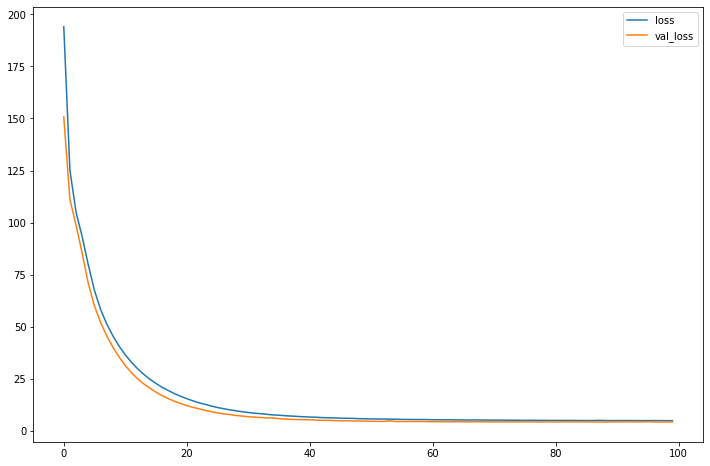

In [376]:
import pandas as pd

loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))


In [377]:
Y_pred = model.predict(X_test)

MAE: 1.6322433
MSE: 4.4388514
RMSE: 2.1068583
VarScore: 0.9415145516395569


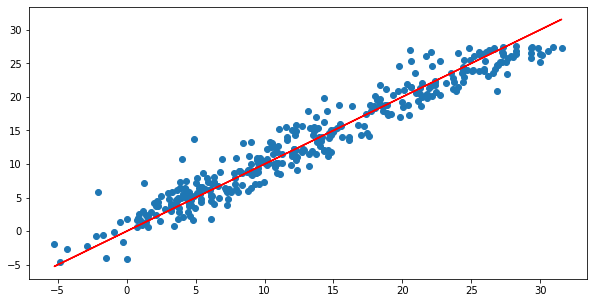

In [378]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('MAE:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('MSE:', metrics.mean_squared_error(Y_test, Y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print('VarScore:',metrics.explained_variance_score(Y_test,Y_pred))

# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(Y_test,Y_pred)
# Perfect predictions
plt.plot(Y_test,Y_test,'r')
plt.show()

In [466]:
def calc_temp_on_day_from_now(day):
    future_X=[]
    future_Y=[]
    future_X.append(X[-1])#nov 6 ide megis a rendes x kell
    future_X.append([future_X[0][0]+1,future_X[0][2],future_X[0][3],future_X[0][4],future_X[0][5],future_X[0][6],future_X[0][7],Y_test[-1]]) #nov 7
    future_X_sc= scaler.transform(future_X)
    
    future_X_sc= np.array(future_X_sc, dtype=np.float32)
    for i in range(day):
        Y_pred = model.predict(future_X_sc)
       # print(Y_pred)
        future_Y=Y_pred
        future_X.append([future_X[-1][0]+1,future_X[-1][2],future_X[-1][3],future_X[-1][4],future_X[-1][5],future_X[-1][6],future_X[-1][7],Y_pred[-1]])
        future_X_sc= scaler.transform(future_X)
        future_X_sc= np.array(future_X_sc, dtype=np.float32)
    return future_Y
      #  print(future_X)
       
    

In [470]:
#so calc temp for the days...


#nov. 8 (312th day of the year) (2 days from out last data)
pred_Y=calc_temp_on_day_from_now(2)
pred_nov_8=pred_Y[-1]
print('Predicted temp for nov. 8th:'+str(pred_nov_8))
#nov. 15 (319th day of the year) (9 days from out last data)
pred_Y=calc_temp_on_day_from_now(9)
pred_nov_15=pred_Y[-1]
print('Predicted temp for nov. 15th:'+str(pred_nov_15))

#pred_nov_15=calc_temp_on_day_from_now(9)

#dec. 6 (340th day of the year) (30 days from out last data)
pred_Y=calc_temp_on_day_from_now(30)
pred_dec_6=pred_Y[-1]
print('Predicted temp for dec. 6th:'+str(pred_dec_6))
#pred_nov_15=calc_temp_on_day_from_now(30)

Predicted temp for nov. 8th:[10.054119]
Predicted temp for nov. 15th:[10.44964]
Predicted temp for dec. 6th:[10.987575]
